<a href="https://colab.research.google.com/github/Omerizdn/Churn/blob/main/FIRST_DRAFT_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-6946299ed764>:53: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


Random Forest Model
Accuracy: 0.6237359478466198
Precision: 0.62194995327588
Recall: 0.6188655852877364
F1 Score: 0.6237278094088538


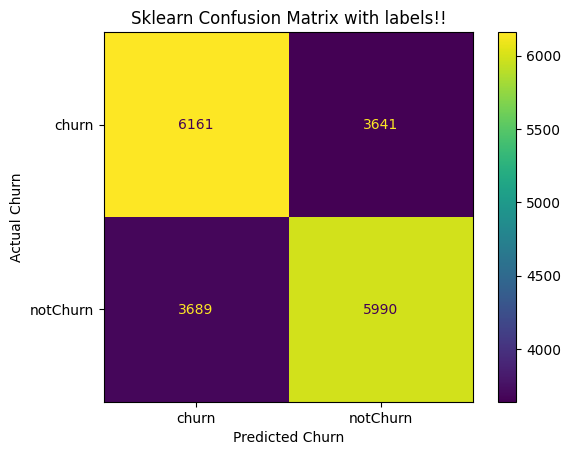

[LightGBM] [Info] Number of positive: 38723, number of negative: 39199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5739
[LightGBM] [Info] Number of data points in the train set: 77922, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496946 -> initscore=-0.012217
[LightGBM] [Info] Start training from score -0.012217
Light GBM Model
Accuracy: 0.6391869000564653
Precision: 0.6337573187966888
Recall: 0.6486207252815374
F1 Score: 0.6391644544482391


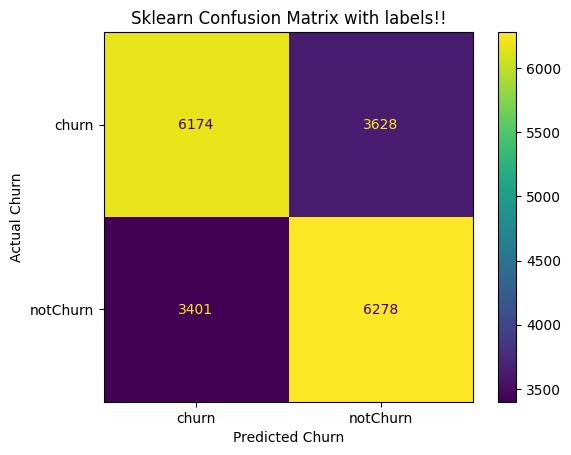

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read data
df = pd.read_csv('/content/Telecom_Churn.csv')

# Function to handle missing values
def fill_missing_values(df):
    numerical_features = ['avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean']
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())
    df['hnd_webcap'] = df['hnd_webcap'].fillna('UNKW')
    return df.dropna()

# Remove unnecessary columns
df.drop(['numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod'], axis=1, inplace=True)

# Handle missing values
df = fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat = []
for feature in df.columns:
    predominant = (df[feature].value_counts()/len(df)).sort_values(ascending=False).values[0]
    if predominant > 0.998:
        quasi_constant_feat.append(feature)

df.drop(columns=quasi_constant_feat, inplace=True)

# Remove duplicated features
duplicated_feat = []
for i in range(0, len(df.columns), 10):
    col_1 = df.columns[i]
    for col_2 in df.columns[i+1:]:
        if df[col_1].equals(df[col_2]):
            duplicated_feat.append(col_2)

df.drop(columns=duplicated_feat, inplace=True)

# Remove correlated features
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df, 0.8)
df = df.drop(columns=corr_features)

# Categorical Encoding
def encode_categorical_features(df, encoding_method):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col] = encoding_method(df[col])
    return df

# Count Encoding
def count_encoding(col):
    counts_map = col.value_counts().to_dict()
    return col.map(counts_map)

# Ordinal Encoding
def ordinal_encoding(col):
    ordered_labels = col.groupby(col).mean().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    return col.map(ordinal_label)

# Mean Encoding
def mean_encoding(col):
    ordered_labels = col.groupby(col).mean().to_dict()
    return col.map(ordered_labels)

df = encode_categorical_features(df, count_encoding)
df = encode_categorical_features(df, ordinal_encoding)
df = encode_categorical_features(df, mean_encoding)

# Split data
X = df.drop(labels=['Customer_ID', 'churn'], axis=1)
y = df['churn']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

# Modeling function
def modeling(alg, alg_name, params={}):
    model = alg(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    print(f'{alg_name} Model')
    print(f'Accuracy: {accuracy_score(y_valid, y_pred)}')
    print(f'Precision: {precision_score(y_valid, y_pred)}')
    print(f'Recall: {recall_score(y_valid, y_pred)}')
    print(f'F1 Score: {f1_score(y_valid, y_pred, average="weighted")}')

    cm = confusion_matrix(y_valid, y_pred)
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['churn', 'notChurn'])
    cmd_obj.plot()
    cmd_obj.ax_.set(title='Sklearn Confusion Matrix with labels!!', xlabel='Predicted Churn', ylabel='Actual Churn')
    plt.show()

# Random Forest Classifier Model
modeling(RandomForestClassifier, 'Random Forest')

# LightGBM model
modeling(lgbm.LGBMClassifier, 'Light GBM', {'n_estimators': 100, 'random_state': 42})

In [2]:
#install.packages("randomForest")
#install.packages("lightgbm")
install.packages("caret")
library(data.table)
library(randomForest)
library(lightgbm)
library(caret)

# Read data
df <- fread("/content/Telecom_Churn.csv")

# Function to handle missing values
fill_missing_values <- function(df) {
  numerical_features <- c('avg6qty', 'avg6rev', 'avg6mou', 'change_mou', 'change_rev', 'rev_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean')
  df[, (numerical_features) := lapply(.SD, function(x) ifelse(is.na(x), mean(x, na.rm = TRUE), x)), .SDcols = numerical_features]
  df[, hnd_webcap := ifelse(is.na(hnd_webcap), 'UNKW', hnd_webcap)]
  return(df[complete.cases(df)])
}

# Remove unnecessary columns
cols_to_remove <- c('numbcars', 'dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'lor', 'income', 'adults', 'prizm_social_one', 'infobase', 'crclscod')
df <- df[, !(names(df) %in% cols_to_remove), with = FALSE]

# Handle missing values
df <- fill_missing_values(df)

# Drop constant and quasi-constant features
quasi_constant_feat <- c()
for (feature in names(df)) {
  predominant <- max(table(df[[feature]])/nrow(df))
  if (predominant > 0.998) {
    quasi_constant_feat <- c(quasi_constant_feat, feature)
  }
}
df <- df[, !(names(df) %in% quasi_constant_feat), with = FALSE]

# Remove duplicated features
df <- df[, !duplicated(df), with = FALSE]

# Categorical Encoding
encode_categorical_features <- function(df, encoding_method) {
  cat_cols <- names(df)[sapply(df, is.character)]
  for (col in cat_cols) {
    df[[col]] <- encoding_method(df[[col]])
  }
  return(df)
}

# Count Encoding
count_encoding <- function(col) {
  counts_map <- as.list(table(col))
  return(col %in% names(counts_map))
}

# Ordinal Encoding
ordinal_encoding <- function(col) {
  ordered_labels <- names(sort(tapply(col, col, mean)))
  ordinal_label <- setNames(seq_along(ordered_labels) - 1, ordered_labels)
  return(ordinal_label[col])
}

# Mean Encoding
mean_encoding <- function(col) {
  ordered_labels <- tapply(col, col, mean)
  return(ordered_labels[col])
}

df <- encode_categorical_features(df, count_encoding)
df <- encode_categorical_features(df, ordinal_encoding)
df <- encode_categorical_features(df, mean_encoding)

# Split data
set.seed(42)
train_data <- df[1:floor(0.8 * .N)]
valid_data <- df[(floor(0.8 * .N) + 1):.N]

X_train <- train_data[, !c("Customer_ID", "churn"), with = FALSE]
y_train <- train_data$churn
X_valid <- valid_data[, !c("Customer_ID", "churn"), with = FALSE]
y_valid <- valid_data$churn

# Standardize data using caret
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train <- predict(scaler, X_train)
X_valid <- predict(scaler, X_valid)

# Modeling function for Random Forest and LightGBM
modeling <- function(alg, alg_name) {
  # Ensure y_train is treated as a factor
  y_train <- factor(y_train, levels = c(0, 1))

  # Set levels of y_valid to be the same as y_train
  y_valid <- factor(y_valid, levels = levels(y_train))

  model <- alg(X_train, y_train)
  y_pred <- predict(model, X_valid)

  cat(paste0(alg_name, " Model\n"))
  cat(paste0("Accuracy: ", confusionMatrix(y_pred, y_valid)$overall["Accuracy"], "\n"))
  cat(paste0("Precision: ", confusionMatrix(y_pred, y_valid)$byClass["Precision"], "\n"))
  cat(paste0("Recall: ", confusionMatrix(y_pred, y_valid)$byClass["Sensitivity"], "\n"))
  cat(paste0("F1 Score: ", confusionMatrix(y_pred, y_valid)$byClass["F1"], "\n"))

  cm <- as.matrix(confusionMatrix(y_valid, y_pred)$table)
  colnames(cm) <- c("churn", "notChurn")
  rownames(cm) <- c("churn", "notChurn")
  print(cm)
}

# Random Forest Classifier Model
modeling(randomForest, 'Random Forest')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice



Random Forest Model
Accuracy: 0.653907332341321
Precision: 0.686921202274574
Recall: 0.745219000616903
F1 Score: 0.714883543982754
          Reference
Prediction churn notChurn
  churn     8456     2891
  notChurn  3854     4288
